<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/Camadas_Lineares_Ativacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camadas Lineares e Funções de Ativação



In [1]:
import torch
import torch.nn as nn

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2, non_linearity=True):
        super().__init__()
        self.non_linearity = non_linearity
        self.layers = nn.ModuleList()
        in_dim = input_size

        # Hidden layers
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(in_dim, hidden_size))
            in_dim = hidden_size

        # Output layer
        self.output_layer = nn.Linear(in_dim, 1)
        self.activation_fn = nn.Sigmoid() if non_linearity else nn.Identity()

    def forward(self, x):
        activations = []
        for layer in self.layers:
            x = layer(x)
            if self.non_linearity:
                x = self.activation_fn(x)
            activations.append(x)
        out = self.output_layer(x)
        if self.non_linearity:
            out = self.activation_fn(out)
        activations.append(out)
        return out, activations

In [16]:
import numpy as np

from sklearn.datasets import make_circles
from torch.utils.data import DataLoader, TensorDataset

In [55]:
X, y = make_circles(n_samples=200, noise=0.0, factor=0.4, random_state=42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = MLP(input_size=X.shape[1], hidden_size=2, n_layers=3, non_linearity=True)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

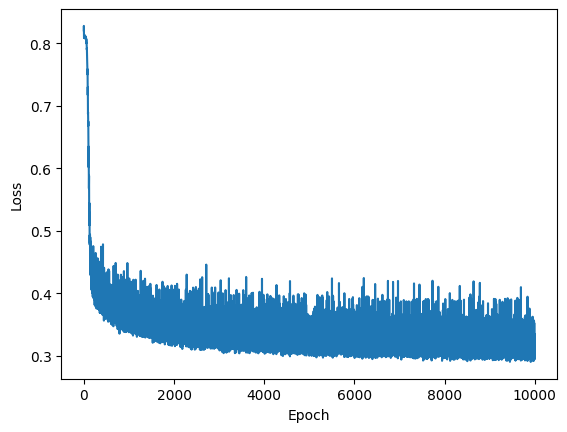

In [56]:
num_epochs = 10_000
loss_logs = []

for epoch in range(num_epochs):

    # Start epoch loss
    running_loss = 0.0

    for b, (X_batch, y_batch) in enumerate(dataloader):

        # Forward pass
        outputs, _ = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Update epoch loss
    loss_logs.append(running_loss/b)

# Plot loss
plt.plot(loss_logs)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [20]:
import matplotlib.pyplot as plt

In [57]:
@torch.no_grad()
def plot_decision_boundary(model, X, y, show_activations=False, resolution=0.01, cmap='cividis'):
    """
    Plot the decision boundary for a 2D torch model.

    Args:
        model: torch.nn.Module that outputs predictions or (pred, activations)
        X: torch.Tensor of shape (N, 2)
        y: torch.Tensor of shape (N,) or (N,1)
        show_activations: if True, also plot intermediate activations as subplots
        resolution: grid resolution for the mesh
        cmap: color map for contour plot
    """
    device = next(model.parameters()).device
    X, y = X.to(device), y.to(device)

    # Build grid
    x_min, x_max = X[:, 0].min().item(), X[:, 0].max().item()
    y_min, y_max = X[:, 1].min().item(), X[:, 1].max().item()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32, device=device)

    # Model prediction (handle models returning activations)
    output = model(grid)
    if isinstance(output, tuple):  # (y_pred, activations)
        Z, activations = output
    else:
        Z, activations = output, None

    # Convert logits to binary predictions
    if Z.ndim > 1 and Z.shape[1] == 1:
        Z = Z.squeeze(1)
    Z = torch.sigmoid(Z) if Z.dtype.is_floating_point else Z
    Z = (Z > 0.5).float()
    Z = Z.cpu().numpy().reshape(xx.shape)

    # Main plot
    contour = plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap, antialiased=True)
    plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), s=10, label="Class 0")
    plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), s=10, label="Class 1")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x₀')
    plt.ylabel('x₁')
    plt.legend()

    # Optionally show activations
    print(len(activations))
    for i, activation in enumerate(activations):
        n_neurons = activation.shape[1]
        fig, axes = plt.subplots(1, n_neurons, figsize=(4 * n_neurons, 4))
        if n_neurons == 1:
            axes = [axes]
        a = activation.detach().cpu().numpy()
        for i in range(n_neurons):
            Z = a[:, i].reshape(xx.shape)  # only first neuron
            axes[i].contourf(xx, yy, Z, alpha=0.5, cmap=cmap, antialiased=True)
            axes[i].set_title(f"Layer {i+1} activation")
            axes[i].set_xlabel('x₀')
            axes[i].set_ylabel('x₁')
        plt.tight_layout()

    plt.show()

3


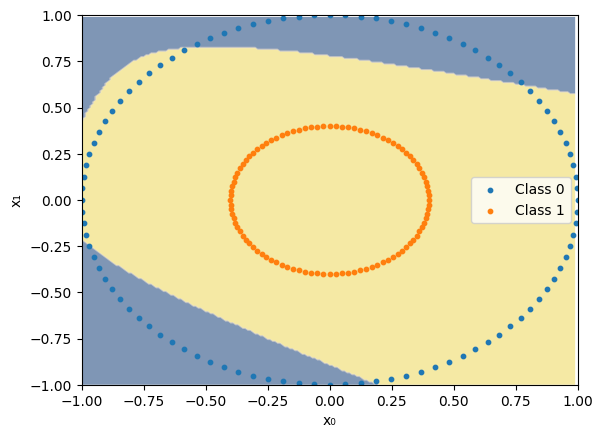

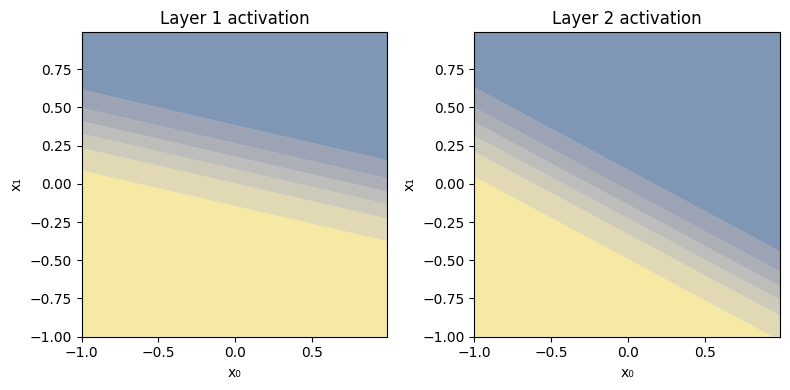

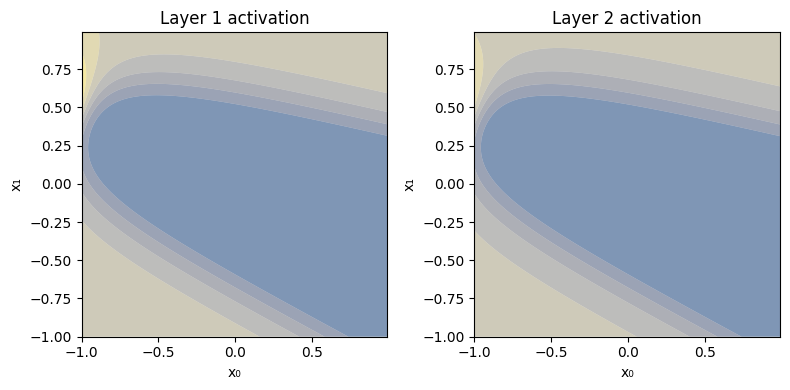

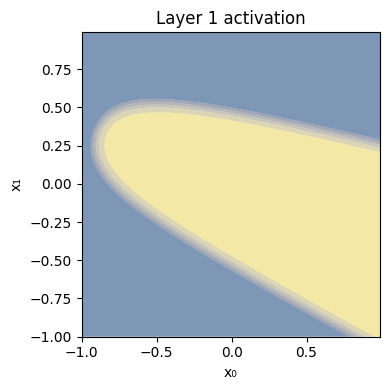

In [58]:
plot_decision_boundary(model, X, y[:,0], show_activations=True)

# Desbravando do Multilayer Perceptron

Vamos entender, então, como o Perceptron Multicamadas consegue resolver o problema proposto. Para isto, vamos analisar cada neurônio e entender um pouco sobre a função de ativação.

## Analisando a Camada Oculta

Para entender o que ocorre dentro deste modelo, vamos criar uma classe para facilitar o acesso à sua camada oculta.

In [ ]:
class MLProbe():
    def __init__(self, model, probe_position=0):
        self.model = model
        self.probe_position = probe_position

    def predict(self, X):
        self.model.forward(X)
        return model.hidden_output[:,self.probe_position]

Assim, vamos analisar separadamente a saída de cada um dos três _perceptrons_ da camada oculta.

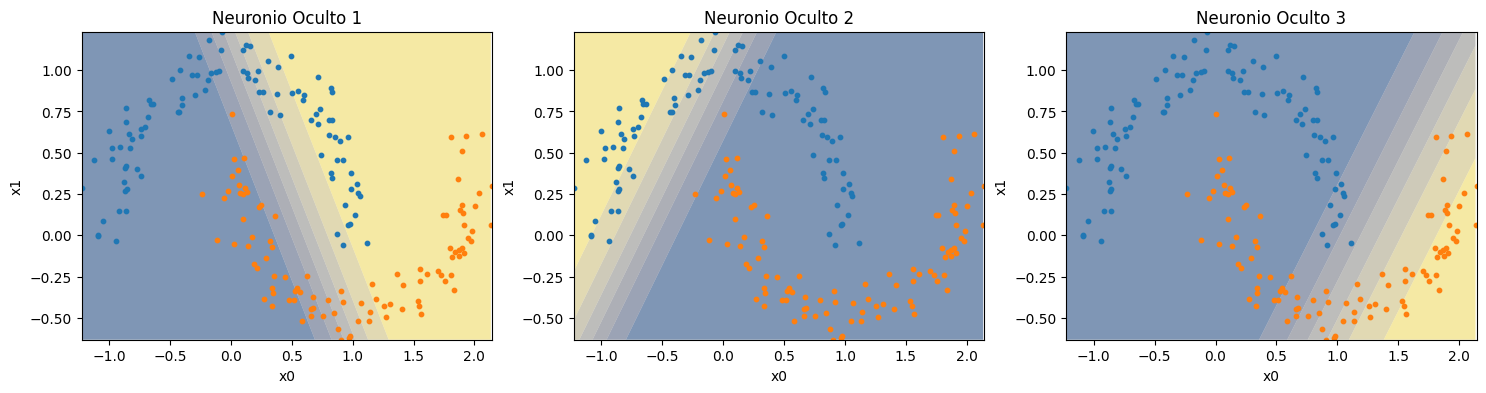

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))
for i in range(3):
    probed_model = MLProbe(model, i)
    axs[i].set_title(f'Neuronio Oculto {i+1}')
    plot_decision_boundary(probed_model, X, y[:,0], axis=axs[i])

Conseguimos verificar que cada _perceptron_ da camada oculta cria uma borda de classificação linear, cada uma em uma região diferente. Ao combinarmos estas bordas de decisão no _perceptron_ da camada de saída, temos a saída com borda não-linear.

## Função de Ativação

Um ponto interessante que verificamos nas saídas dos perceptrons multicamadas é que a borda de classificação apresenta um variação gradual entre uma classe e outra. Isto ocorre porque, ao invés de utilizarmos a função de ativação do _perceptron_ original, utilizamos a função sigmóide, definida abaixo.

$$\delta(x) = \frac{1}{1+e^{-x}}$$

No gráfico a seguir conseguimos verificar o formato desta função, que parece um "S". Para valores muito baixos de $x$, o valor de saída da função é próximo a zero. Porém, a medida que $x$ se aproxima de 0, a saída começa a aumentar até chegar em 0.5. Após isto, enquanto o valor de $x$ aumenta, a saída da função aumenta até se aproximar do valor de 1.0.

De certa forma, esta função é parecida com a função de ativação do _perceptron_. Porém, esta função tem como característica ser contínua e derivável, o que permite o treinamento do perceptron multicamadas.

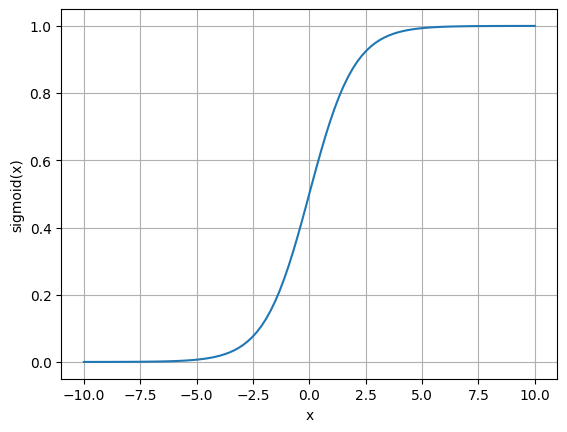

In [ ]:
x = np.linspace(-10,10,100)
y = 1/(1+np.exp(-x))

plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.show()

## Otimização

Por fim, ocorre a etapa de otimização da rede neural, cujo propósito é ajustar os pesos do modelo de forma a minimizar o erro de predição. Isso é viabilizado pelo algoritmo de _backpropagation_, introduzido em 1986, um marco decisivo na história da inteligência artificial. A partir dos gradientes calculados por _backpropagation_, os parâmetros de redes neurais com múltiplas camadas podem ser atualizados iterativamente por meio do método de descida do gradiente, reduzindo progressivamente o erro do modelo.


# Exercícios


1. Modifique a chamada do Perceptron Multicamadas para utilizar apenas um _perceptron_ na camada oculta. Depois, utilize apenas dois _perceptrons_. Foi possível resolver o problema não-linear? Discuta a resposta e justifique.

1. Reproduza o código do Multilayer Perceptron utilizando Pytorch.

# Referências

- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. nature, 323(6088), 533-536.
